# Skip Gram

这个notebook用`pytorch`的 embedding来实现
用`cuda`进行训练，embedding `dim=8`，降维后plot

可能模型太简单，cuda训练反而比cpu低效

## 准备数据


In [1]:
# pprint
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
sentences = [
    "Cat is animal",
    "Dog is animal",
    "Lion is animal",
    "Bear is animal",
    "Merlin is bird",
    "Pidgen is bird",
    "Cat can run",
    "Dog can run",
    "Lion can run",
    "Merlin can fly",
    "Pidgen can fly",
    "Cat eats fish",
    "Dog eats bone",
    "Lion eats meat",
    "Bear eats fish and meat",
    "Merlin eats meat",
    "Pidgen eats seeds"
]

words = list(set(' '.join(sentences).split()))

pp.pprint(words)

[   'bird',
    'Merlin',
    'Bear',
    'animal',
    'seeds',
    'eats',
    'Dog',
    'is',
    'run',
    'Cat',
    'bone',
    'and',
    'Lion',
    'Pidgen',
    'meat',
    'fly',
    'fish',
    'can']


In [3]:
word_to_idx = {word:idx for idx,word in enumerate(words)}
pp.pprint(word_to_idx)    

{   'Bear': 2,
    'Cat': 9,
    'Dog': 6,
    'Lion': 12,
    'Merlin': 1,
    'Pidgen': 13,
    'and': 11,
    'animal': 3,
    'bird': 0,
    'bone': 10,
    'can': 17,
    'eats': 5,
    'fish': 16,
    'fly': 15,
    'is': 7,
    'meat': 14,
    'run': 8,
    'seeds': 4}


In [4]:
windows_size = 2
voc_size = len(word_to_idx)
def create_skipgram_dataset():
    skipgram_data = []
    for sentence in sentences:
        sentence_words = sentence.split()
        for idx,target in enumerate(sentence_words):
            left = max(idx-windows_size,0)
            right = min(idx+windows_size+1,len(sentence_words))
            for neighber in sentence_words[left:right]:
                if neighber != target:
                    skipgram_data.append((neighber,target))
                
            
    return skipgram_data

skipgram_dataset = create_skipgram_dataset()

pp.pprint(skipgram_dataset)
        
            

[   ('is', 'Cat'),
    ('animal', 'Cat'),
    ('Cat', 'is'),
    ('animal', 'is'),
    ('Cat', 'animal'),
    ('is', 'animal'),
    ('is', 'Dog'),
    ('animal', 'Dog'),
    ('Dog', 'is'),
    ('animal', 'is'),
    ('Dog', 'animal'),
    ('is', 'animal'),
    ('is', 'Lion'),
    ('animal', 'Lion'),
    ('Lion', 'is'),
    ('animal', 'is'),
    ('Lion', 'animal'),
    ('is', 'animal'),
    ('is', 'Bear'),
    ('animal', 'Bear'),
    ('Bear', 'is'),
    ('animal', 'is'),
    ('Bear', 'animal'),
    ('is', 'animal'),
    ('is', 'Merlin'),
    ('bird', 'Merlin'),
    ('Merlin', 'is'),
    ('bird', 'is'),
    ('Merlin', 'bird'),
    ('is', 'bird'),
    ('is', 'Pidgen'),
    ('bird', 'Pidgen'),
    ('Pidgen', 'is'),
    ('bird', 'is'),
    ('Pidgen', 'bird'),
    ('is', 'bird'),
    ('can', 'Cat'),
    ('run', 'Cat'),
    ('Cat', 'can'),
    ('run', 'can'),
    ('Cat', 'run'),
    ('can', 'run'),
    ('can', 'Dog'),
    ('run', 'Dog'),
    ('Dog', 'can'),
    ('run', 'can'),
    ('Dog', 'run

## 定义模型

In [7]:
import torch.nn as nn
import torch

device = torch.device("cuda")

class SkipGramEmbedding(nn.Module):
    def __init__(self,voc_size,embedding_size):
        super(SkipGramEmbedding,self).__init__()
        self.input_to_hidden = nn.Embedding(voc_size,embedding_dim=embedding_size).to(device=device)
        self.hidden_to_output = nn.Linear(embedding_size,voc_size,bias=False).to(device=device)
    
    def forward(self,X):
        hidden = self.input_to_hidden(X)
        output = self.hidden_to_output(hidden)
        return output
    

skipgram_model = SkipGramEmbedding(voc_size=voc_size,embedding_size=8)
print(skipgram_model)
        

SkipGramEmbedding(
  (input_to_hidden): Embedding(18, 8)
  (hidden_to_output): Linear(in_features=8, out_features=18, bias=False)
)


## 训练

Epoch:100,Loss:2.4968302602117713
Epoch:200,Loss:2.346340061859651
Epoch:300,Loss:2.2506514966487883
Epoch:400,Loss:2.1749401065436276
Epoch:500,Loss:2.1125273059714926
Epoch:600,Loss:2.0599603062326257
Epoch:700,Loss:2.014276028763164
Epoch:800,Loss:1.9733794737945904
Epoch:900,Loss:1.9364320386539806
Epoch:1000,Loss:1.9036463065580889
Epoch:1100,Loss:1.875350521369414
Epoch:1200,Loss:1.8511877087029545
Epoch:1300,Loss:1.830361346764998
Epoch:1400,Loss:1.8121769980950788
Epoch:1500,Loss:1.7961892610246486
Epoch:1600,Loss:1.7821347870609976
Epoch:1700,Loss:1.769827010414817
Epoch:1800,Loss:1.759098721634258
Epoch:1900,Loss:1.7497821401466023
Epoch:2000,Loss:1.7417141470042141
Epoch:2100,Loss:1.7347372423518788
Epoch:2200,Loss:1.7287045067006892
Epoch:2300,Loss:1.7234828461300242
Epoch:2400,Loss:1.7189497221599925
Epoch:2500,Loss:1.714999019015919
Epoch:2600,Loss:1.7115402861074969
Epoch:2700,Loss:1.7084975204684518
Epoch:2800,Loss:1.7058080754496834
Epoch:2900,Loss:1.7034195032986728
E

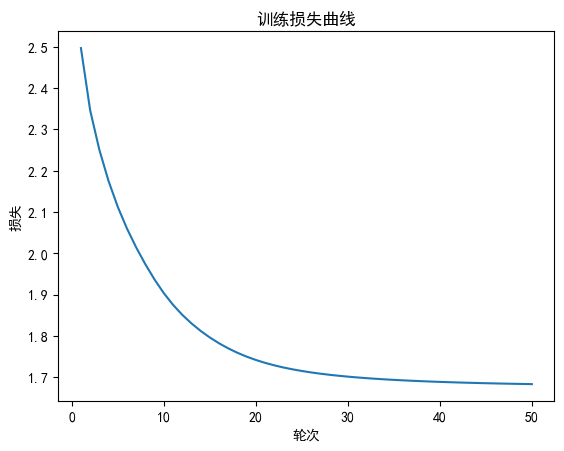

In [9]:
import torch.optim as optim

lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(skipgram_model.parameters(),lr=lr)

epochs=5000

loss_values = []

for epoch in range(epochs):
    loss_sum = 0
    
    for context,target in skipgram_dataset:
        X = torch.tensor([word_to_idx[target]],dtype=torch.long).to(device)
        y_pred = skipgram_model(X).to(device)
        y_true = torch.tensor([word_to_idx[context]],dtype=torch.long).to(device)
        loss = criterion(y_pred,y_true)
        loss_sum+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch:{epoch+1},Loss:{loss_sum/len(skipgram_dataset)}")
        loss_values.append(loss_sum/len(skipgram_dataset))

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
plt.plot(range(1, epochs // 100 + 1), loss_values)
plt.title("训练损失曲线")
plt.xlabel("轮次")
plt.ylabel("损失")
plt.show()

## 查看词向量

In [12]:
w = skipgram_model.input_to_hidden.weight.cpu()
pp.pprint(w)

tensor([[ 0.6107,  0.2761, -0.9057, -0.8565, -2.0999,  1.5490,  1.5694, -0.1664],
        [-1.9006, -1.5186, -1.5674, -0.1891, -0.4508,  1.7784,  0.8316,  0.6447],
        [-0.1676,  2.3204, -0.5484, -0.9820,  1.0837,  1.5301, -1.1787, -0.9821],
        [ 0.3450,  2.3179, -1.1366, -0.6121, -2.6786, -2.6581, -1.0354, -1.5717],
        [ 1.4733,  0.1889, -0.0287,  0.0721, -0.7559,  1.4090,  0.1831, -2.5982],
        [-1.0443,  0.4131,  1.6193, -1.5164, -0.3568, -1.1966,  0.6093, -1.6840],
        [ 0.6564, -0.6279, -0.1372,  1.1937, -1.2686,  1.1826, -1.6922, -0.5789],
        [ 1.8810,  3.2945,  1.1797,  0.0139,  1.6832,  0.4443,  0.1510,  1.4184],
        [ 1.1736, -1.9892,  1.1300,  1.1074,  2.0752, -1.9049,  0.2900, -0.8346],
        [ 0.6559, -0.1241, -1.0204, -1.6296,  0.8672,  1.7270, -1.6510, -0.1328],
        [ 1.1752,  0.1039, -2.2681, -0.4798,  2.4726, -1.2399, -2.1769, -1.5186],
        [-1.3849, -0.1779, -1.4912, -1.5919,  1.2688,  0.6045,  0.5814, -0.8938],
        [-0.7890

In [16]:
for word,idx in word_to_idx.items():
    print(f"{word}:{w[idx,:].detach().numpy()}")

bird:[ 0.6106683   0.2760923  -0.90570825 -0.85651666 -2.0999112   1.5489671
  1.5694352  -0.16637003]
Merlin:[-1.90057    -1.5185739  -1.5674353  -0.18908334 -0.45078433  1.7784474
  0.83164996  0.64470893]
Bear:[-0.16760536  2.3204331  -0.5483841  -0.98201174  1.0837342   1.5300982
 -1.1787329  -0.98207235]
animal:[ 0.3449565  2.3179455 -1.1365889 -0.6121276 -2.6785727 -2.6580577
 -1.0353792 -1.571721 ]
seeds:[ 1.4733063   0.1889427  -0.0287116   0.0721442  -0.755933    1.40898
  0.18312986 -2.5982304 ]
eats:[-1.044316    0.41314325  1.6192861  -1.5164223  -0.35675982 -1.1966065
  0.609299   -1.6839944 ]
Dog:[ 0.6563973  -0.62787336 -0.13724689  1.1936734  -1.2685813   1.182554
 -1.6921622  -0.57892495]
is:[1.8810042  3.2945285  1.1797234  0.01393934 1.6831691  0.44432575
 0.15101042 1.4184272 ]
run:[ 1.1736099  -1.9891962   1.1299682   1.1074107   2.0752075  -1.9049455
  0.28995064 -0.83461046]
Cat:[ 0.6559454  -0.12413099 -1.0203767  -1.629556    0.86718357  1.7269989
 -1.6509894  

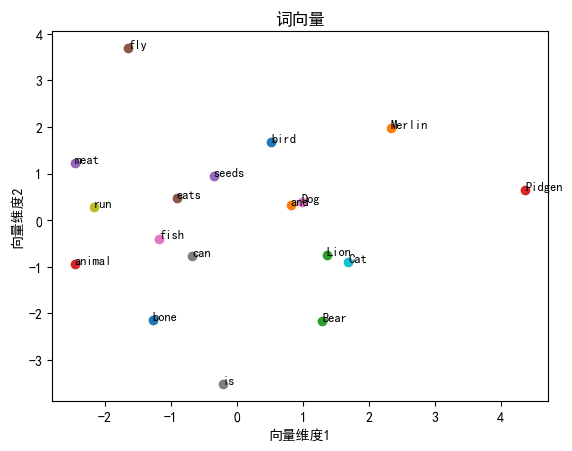

In [26]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

transformed = pca.fit_transform(skipgram_model.input_to_hidden.weight.cpu().detach().numpy())

fig,ax = plt.subplots()
for word,idx in word_to_idx.items():
    vec = transformed[idx,:]
    ax.scatter(vec[0],vec[1])
    ax.annotate(word,(vec[0],vec[1]),fontsize=9)
plt.title('词向量')
plt.xlabel('向量维度1')
plt.ylabel('向量维度2')
plt.show()